<a href="https://colab.research.google.com/github/jeraldflowers/Deep-Learn-PyTorch/blob/main/EntrenarUnaRedNeuronal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #  Capas sin parametros

In [2]:
class Net(nn.Module):
  def __init__(self,num_channels):
    super(Net,self).__init__()

    self.num_channels = num_channels

    self.conv1 = nn.Conv2d(3,self.num_channels, 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)

    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)

  def forward(self, x):
      # Empieza 3x64x64
      x = self.conv1(x) # num_channels x 64 x 64
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
      x = self.conv2(x) # num_channels*2 x 32 x 32
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*2 x 16 x 16
      x = self.conv3(x) # num_channels*4 x 16 x 16
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

      # flatten
      x = x.view(-1, self.num_channels*4*8*8)

      # fc
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)

      # log_softmax
      x = F.log_softmax(x, dim=1)

      return x

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
!ls '/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS'

test_signs  train_signs  val_signs


In [5]:
import sys
sys.path.append('/gdrive/My Drive/dl-pytorch')

In [6]:
from plot_helpers import imshow

In [7]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class SIGNSDataset(Dataset):
  def __init__(self, base_dir, split="train", transform=None):
    path = os.path.join(base_dir, "{}_signs".format(split))
    files = os.listdir(path)

    self.filenames = [os.path.join(path, f) for f in files if f.endswith(".jpg")]

    self.targets = [int(f[0]) for f in files]
    self.transform = transform

  def __len__(self):
    return len(self.filenames)

  def __getitem__(self, idx):
    image = Image.open(self.filenames[idx])
    if self.transform:
      image = self.transform(image)
    return image, self.targets[idx]


In [8]:
signs = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train")

In [9]:
len(signs)

864

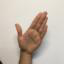

In [10]:
signs[0][0]

In [11]:
import torchvision.transforms as transforms

In [12]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transforms.ToTensor())

In [13]:
dataloader = DataLoader(trainset, batch_size=32)

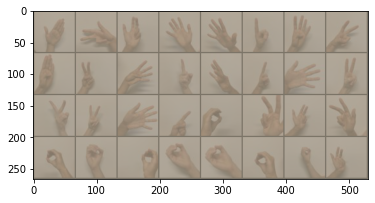

tensor([5, 3, 3, 5, 5, 1, 4, 2, 4, 2, 4, 1, 4, 1, 5, 2, 2, 2, 5, 1, 0, 3, 3, 3,
        0, 0, 0, 0, 0, 0, 0, 3])


In [14]:
from torchvision.utils import make_grid

for inputs, targets in dataloader:
  out = make_grid(inputs)
  imshow(out)
  print(targets)
  break

In [15]:
import torch.optim as optim

In [16]:
device = torch.device('cuda')

In [17]:
net = Net(32).to(device)
loss_fn = nn.NLLLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [18]:
class RunningMetric():
  def __init__(self):
    self.S = 0
    self.N = 0

  def update(self, val, size):
    self.S += val
    self.N += size

  def __call__(self):
    return self.S/float(self.N)

In [19]:
num_epoch = 100

In [20]:
for epoch in range(num_epoch):
  print('Epoch {}/{}'.format(epoch+1, num_epoch))
  print('-'*10)

  running_loss = RunningMetric() # perdida
  running_acc = RunningMetric() # precision

  for inputs, targets in dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()

    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)
    loss = loss_fn(outputs, targets)

    loss.backward() #magias: gradientes calculados automaticamente
    optimizer.step() #magia2: actualiza llas perillas a los parametros

    batch_size = inputs.size()[0]
    running_loss.update(loss.item()*batch_size,
                        batch_size)
    running_acc.update(torch.sum(preds == targets).float(),
                        batch_size)
    
  print(" Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                            running_acc()))



Epoch 1/100
----------
 Loss: 1.7926 Acc: 0.1725 
Epoch 2/100
----------
 Loss: 1.7919 Acc: 0.1725 
Epoch 3/100
----------
 Loss: 1.7914 Acc: 0.1725 
Epoch 4/100
----------
 Loss: 1.7910 Acc: 0.1725 
Epoch 5/100
----------
 Loss: 1.7907 Acc: 0.1725 
Epoch 6/100
----------
 Loss: 1.7904 Acc: 0.1725 
Epoch 7/100
----------
 Loss: 1.7901 Acc: 0.1725 
Epoch 8/100
----------
 Loss: 1.7898 Acc: 0.1725 
Epoch 9/100
----------
 Loss: 1.7894 Acc: 0.1725 
Epoch 10/100
----------
 Loss: 1.7890 Acc: 0.1725 
Epoch 11/100
----------
 Loss: 1.7886 Acc: 0.1725 
Epoch 12/100
----------
 Loss: 1.7882 Acc: 0.1725 
Epoch 13/100
----------
 Loss: 1.7877 Acc: 0.1725 
Epoch 14/100
----------
 Loss: 1.7871 Acc: 0.1725 
Epoch 15/100
----------
 Loss: 1.7865 Acc: 0.1725 
Epoch 16/100
----------
 Loss: 1.7859 Acc: 0.1725 
Epoch 17/100
----------
 Loss: 1.7852 Acc: 0.1863 
Epoch 18/100
----------
 Loss: 1.7844 Acc: 0.2303 
Epoch 19/100
----------
 Loss: 1.7835 Acc: 0.2581 
Epoch 20/100
----------
 Loss: 1.7824 Ac

In [21]:
x = torch.Tensor(2)
x.requires_grad=True
loss = 13*x[0] + 7*x[1] + 1
loss.backward()
print(x)
x.grad

tensor([-3.5850e-20,  0.0000e+00], requires_grad=True)


tensor([13.,  7.])

In [22]:
x = torch.rand((2,3), requires_grad=True)
y = torch.Tensor([[1,2],[3,4]])
loss = y.mm(x)
loss = loss.sum()
loss.backward()
x.grad

tensor([[4., 4., 4.],
        [6., 6., 6.]])

In [23]:
train = True

with torch.set_grad_enabled(train):
  #computos con tensores

SyntaxError: ignored

In [24]:
import optimizers_viz as optviz

In [25]:
problem = optviz.build_beales_problem()
constructors = optviz.build_optimizers(problem.lr)
params = optviz.build_params(problem)

WARN: your minima is not the true minima 3.734217045244883 0.17204512657950802


/gdrive/My Drive/dl-pytorch/optimizers_viz.py:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  return torch.Tensor(x)


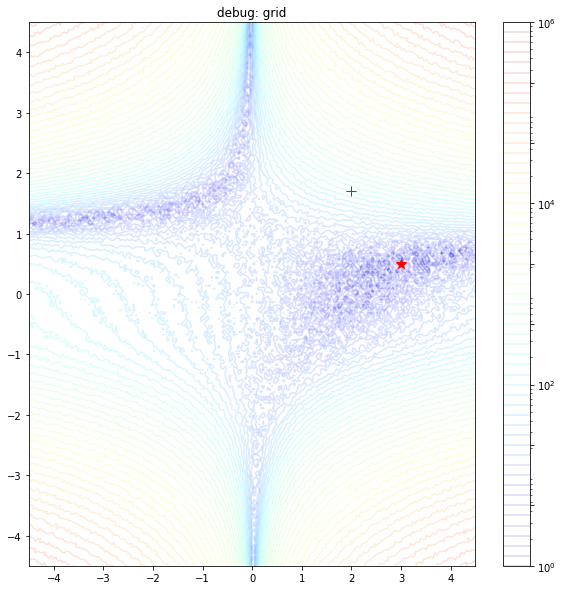

In [26]:
optviz.plot_minimized_function(params)

In [27]:
constructors

{'SGD': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'momentum': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'momentum_dampen': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'nesterov': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'nesterov_decay': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'Adadelta': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'Adagrad': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'Adamax': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'RMSprop': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>,
 'Adam': <function optimizers_viz.build_optimizers.<locals>.<lambda>(params)>}

In [28]:
zpaths, results, distance, lrs = optviz.run_optimizers(problem, constructors, params)

  0%|          | 0/10 [00:00<?, ?it/s]

SGD 178.74652236578427 	 True 	 False
momentum 170.20791751668145 	 True 	 False
momentum_dampen 172.27175286160121 	 True 	 False
nesterov 174.16480579870452 	 True 	 False
nesterov_decay 165.59545319242054 	 True 	 False
Adadelta 177.64571310270503 	 True 	 False
Adagrad 176.33449578290129 	 True 	 False
Adamax 177.20789914355618 	 True 	 False
RMSprop 179.76858162295696 	 True 	 False
Adam 173.2243911428052 	 True 	 False


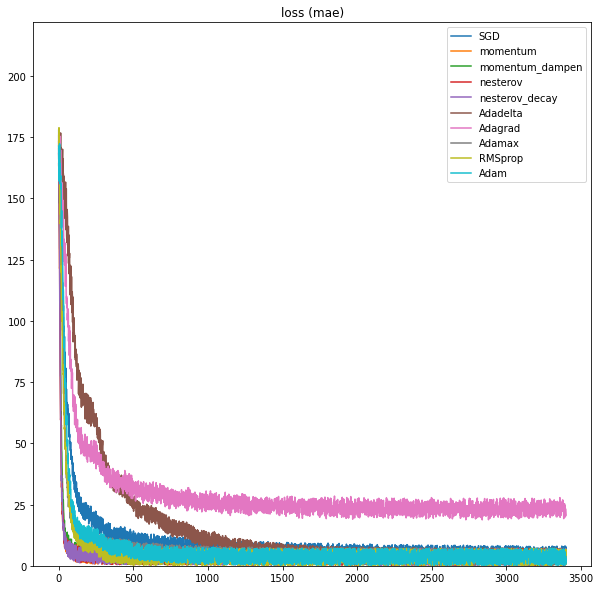

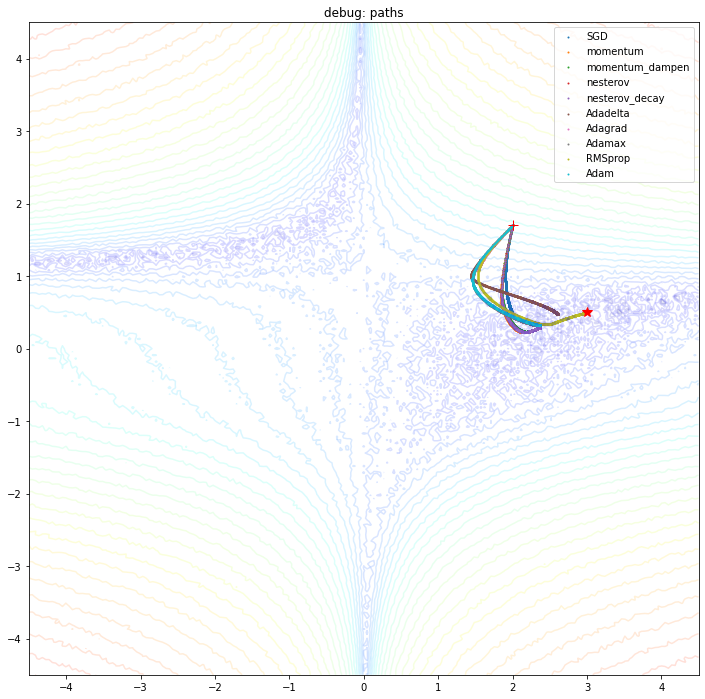

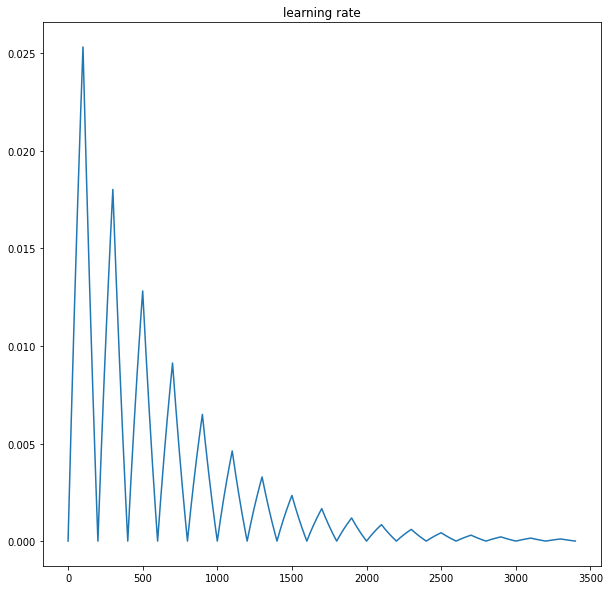

In [29]:
optviz.plot_optim_journeys(zpaths, results, distance, lrs, params)

In [36]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), #data augmentation
     transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))   
    ]
) 

In [37]:
trainset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="train", transform = transform)
trainloader = DataLoader(trainset, batch_size=32)

In [38]:
valset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="val", transform = transform)
valloader = DataLoader(trainset, batch_size=32)

In [39]:
testnset = SIGNSDataset('/gdrive/My Drive/dl-pytorch/datasets/64x64_SIGNS', split="test", transform = transform)
testloader = DataLoader(trainset, batch_size=32)

In [33]:
dataloaders = {'train':trainloader,
               'val':valloader,
               'test':testloader}

In [35]:
class Net(nn.Module):
  def __init__(self,num_channels):
    super(Net,self).__init__()

    self.num_channels = num_channels

    self.conv1 = nn.Conv2d(3,self.num_channels, 3, stride = 1, padding = 1)
    self.bn1 = nn.BatchNorm2d(self.num_channels)
    self.conv2 = nn.Conv2d(self.num_channels, self.num_channels*2, 3, stride = 1, padding = 1)
    self.bn2 = nn.BatchNorm2d(self.num_channels*2)
    self.conv3 = nn.Conv2d(self.num_channels*2, self.num_channels*4, 3, stride = 1, padding = 1)
    self.bn3 = nn.BatchNorm2d(self.num_channels*4)

    self.fc1 = nn.Linear(self.num_channels*4*8*8, self.num_channels*4)
    self.fcbn1 = nn.BatchNorm1d(self.num_channels*4)
    self.fc2 = nn.Linear(self.num_channels*4, 6)

  def forward(self, x):
      # Empieza 3x64x64
      x = self.bn1(self.conv1(x)) # num_channels x 64 x 64
      x = F.relu(F.max_pool2d(x, 2)) # num_channels x 32 x 32
      x = self.bn2(self.conv2(x)) # num_channels*2 x 32 x 32
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*2 x 16 x 16
      x = self.bn3(self.conv3(x)) # num_channels*4 x 16 x 16
      x = F.relu(F.max_pool2d(x, 2)) # num_channels*4 x 8 x 8

      # flatten
      x = x.view(-1, self.num_channels*4*8*8)

      # fc
      x = F.relu(self.fcbn1(self.fc1(x)))
      x = F.dropout(x, p = 0.8, training=True)
      x = self.fc2(x)

      # log_softmax
      x = F.log_softmax(x, dim=1)

      return x

In [40]:
def train_and_evaluate(model, optimizer, lose_fn, dataloaders, device, num_epochs=10, lr=0.001):
  for g in optimizer.param_groups:
    g['lr'] = lr

  for epoch in range(num_epoch):
    print('Epoch {}/{}'.format(epoch+1, num_epoch))
    print('-'*10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      running_loss = RunningMetric() # perdida
      running_acc = RunningMetric() # precision

      for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(phase == 'train'):
          outputs = net(inputs)
          _, preds = torch.max(outputs, 1)
          loss = loss_fn(outputs, targets)
          if phase == 'train':
            loss.backward() #magias: gradientes calculados automaticamente
            optimizer.step() #magia2: actualiza llas perillas a los parametros

        batch_size = inputs.size()[0]
        running_loss.update(loss.item()*batch_size,
                            batch_size)
        running_acc.update(torch.sum(preds == targets).float(),
                            batch_size)
        
      print(" Loss: {:.4f} Acc: {:.4f} ".format(running_loss(),
                                                running_acc()))
  return model

In [41]:
import random
lrs = [10**(-random.randint(3,7)) for _ in range(3)]

In [ ]:
for lr in lrs:
  train_and_evaluate(net, optimizer, loss_fn, dataloaders, device, 10, lr)